In [1]:
import os
import sys

In [2]:
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/Insurance_claims_data.csv')

print(df.shape)
df.head()

test_df = df.sample(20000, random_state=23)

# Create train/test split with stratification since data is imbalanced
X = test_df.drop('claim_status', axis=1)
y = test_df['claim_status']

# Use stratify parameter to maintain class distribution in both splits
# Use test_size=0.2 for 80/20 split which is common practice
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42, # For reproducibility
    stratify=y # Maintain class distribution
)

# Print shapes to verify split
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("\nClass distribution in splits:")
print("Training set:", pd.Series(y_train).value_counts(normalize=True))
print("Test set:", pd.Series(y_test).value_counts(normalize=True))


(58592, 41)
Training set shape: (16000, 40)
Test set shape: (4000, 40)

Class distribution in splits:
Training set: claim_status
0    0.935063
1    0.064937
Name: proportion, dtype: float64
Test set: claim_status
0    0.935
1    0.065
Name: proportion, dtype: float64


In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
from xgboost import XGBClassifier

from src.modules.fe import CAAFETransformer

model = XGBClassifier(
        seed=42,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        use_label_encoder=False,
        verbosity=0,
        enable_categorical=False,
    )

fe = CAAFETransformer(
    llm_model='gpt-4.1-mini',
    optimization_metric="ppv",
    top_p=0.05,
    target_name="claim_status",
    dataset_description="Insurance claim data.",
    max_features=1,
    iterations=5,
    n_splits=5,
    n_repeats=2,
    random_state=123,
    base_classifier=model,
)

In [10]:
fe.fit(X_train, y_train, show_prompts=True)

[2025-06-07 22:07:34] INFO:src.modules.fe.CAAFETransformer: Starting CAAFETransformer.fit(): running iterative feature engineering.
[2025-06-07 22:07:34] INFO:src.modules.fe.CAAFETransformer: CAAFE transformer initialization completed:
  Target: claim_status
  Dataset shape: (16000, 41)
  Original features: 40
  Max features per iteration: 1
  Max iterations: 5
  Optimization metric: ppv
  LLM model: gpt-4.1-mini
  CV splits: 5
  CV repeats: 2
[2025-06-07 22:07:34] INFO:src.modules.fe.CAAFETransformer: Starting iterative feature engineering process...
[2025-06-07 22:07:34] INFO:src.modules.fe.CAAFETransformer: 

→ Evaluating baseline performance (no added features)...

[2025-06-07 22:07:42] INFO:src.modules.fe.CAAFETransformer: 
Baseline ROC AUC: 0.539 (±0.021)
[2025-06-07 22:07:42] INFO:src.modules.fe.CAAFETransformer: 
Baseline Accuracy: 0.934 (±0.005)
[2025-06-07 22:07:42] INFO:src.modules.fe.CAAFETransformer: 
Baseline PPV@5.0%: 0.079 (±0.024)
[2025-06-07 22:07:42] INFO:src.modules

CAAFETransformer(base_classifier=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None,
                                               feature_weights=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_const...
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=-1,
                                               num_parallel_tree=None, ...),
                 dataset_description='Insurance claim data.', iterations=5,
                 llm_model='gpt-4.1-mini',
                 logger=<Logger src.modules.fe.CAAFETransformer (INFO)>,
                 max_features=1, n_splits=5, optimization_metric='ppv',
                 random_state=123, target_name='claim_status')

In [11]:
fe.save_code("features.py")

[2025-06-07 22:11:56] INFO:src.modules.fe.CAAFETransformer: Feature-generation code saved to features.py


In [12]:
fe.usages

[Usage(requests=6, request_tokens=30871, response_tokens=756, total_tokens=31627, details={'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0, 'cached_tokens': 28416}),
 Usage(requests=5, request_tokens=24650, response_tokens=442, total_tokens=25092, details={'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0, 'cached_tokens': 22400}),
 Usage(requests=4, request_tokens=17484, response_tokens=755, total_tokens=18239, details={'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0, 'cached_tokens': 7552}),
 Usage(requests=4, request_tokens=17979, response_tokens=422, total_tokens=18401, details={'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0, 'cached_tokens': 14080}),
 Usage(requests=5, request_tokens=26808, response_tokens=841, total_tokens=27649, details={'accepted_

In [13]:
print(fe.get_formatted_agent_notepad(n=-1))

Iteration 1
Features created: vehicle_safety_score
Features dropped: gross_weight, width
Performance before adding features ROC 0.5392, ACC 0.9338, PPV@5.0% 0.07875.
Performance after adding features ROC 0.541, ACC 0.9331, PPV@5.0% 0.07688.
Improvement ROC +0.001834, ACC -0.0006875, PPV -0.001875.
Primary optimization metric (ppv): -0.001875.
Note: Code was REJECTED and NOT applied to the dataset.

Iteration 2
Features created: age_and_experience
Features dropped: displacement
Performance before adding features ROC 0.5392, ACC 0.9338, PPV@5.0% 0.07875.
Performance after adding features ROC 0.5377, ACC 0.9343, PPV@5.0% 0.08.
Improvement ROC -0.001454, ACC +0.0005, PPV +0.00125.
Primary optimization metric (ppv): +0.00125.
Note: Code was ACCEPTED and applied to the dataset. Columns were successfully added/dropped.

Iteration 3
Features created: vehicle_load_efficiency
Features dropped: policy_id, is_power_steering, airbags, segment
Performance before adding features ROC 0.5377, ACC 0.934

In [6]:
fe.fit(X_train, y_train, load_code_path="features.py")

[2025-06-07 22:28:21] INFO:src.modules.fe.CAAFETransformer: Starting CAAFETransformer.fit(): running iterative feature engineering.
[2025-06-07 22:28:21] INFO:src.modules.fe.CAAFETransformer: CAAFE transformer initialization completed:
  Target: claim_status
  Dataset shape: (16000, 41)
  Original features: 40
  Max features per iteration: 1
  Max iterations: 5
  Optimization metric: ppv
  LLM model: gpt-4.1-mini
  CV splits: 5
  CV repeats: 2
[2025-06-07 22:28:21] INFO:src.modules.fe.CAAFETransformer: Loading existing feature-generation code from features.py
[2025-06-07 22:28:21] INFO:src.modules.fe.CAAFETransformer: Feature code loaded successfully (took 0.01s)


CAAFETransformer(base_classifier=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None,
                                               feature_weights=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_const...
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=-1,
                                               num_parallel_tree=None, ...),
                 dataset_description='Insurance claim data.', iterations=5,
                 llm_model='gpt-4.1-mini',
                 logger=<Logger src.modules.fe.CAAFETransformer (INFO)>,
                 max_features=1, n_splits=5, optimization_metric='ppv',
                 random_state=123, target_name='claim_status')

In [7]:
X_transformed = fe.transform(X_train)
print(X_transformed.shape)
X_transformed.head()

(16000, 40)


,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
7047,POL045937,0.5,0.0,47,C7,6112,A,M1,CNG,60Nm@3500rpm,...,No,No,No,No,Yes,No,No,No,Yes,0
25110,POL043655,0.9,2.4,38,C2,27003,B2,M6,Petrol,113Nm@4400rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2
58586,POL036713,1.5,3.2,39,C9,17804,A,M3,Petrol,91Nm@4250rpm,...,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2
56582,POL044861,0.8,2.6,49,C9,17804,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3
5304,POL033737,4.3,0.8,58,C14,7788,A,M1,CNG,60Nm@3500rpm,...,No,No,No,No,Yes,No,No,No,Yes,0


In [8]:
from sklearn.preprocessing import OrdinalEncoder


categorical_cols = [
    col
    for col in X_transformed.columns
    if (
        X_transformed[col].dtype == "object"
        or pd.api.types.is_categorical_dtype(X_transformed[col])
    )
    and col != 'claim_status'
]

# Prepare encoder
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# Fit only on train set
df_train_cats = X_transformed[categorical_cols].astype(str)
encoder.fit(df_train_cats)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [9]:
X_transformed[categorical_cols] = encoder.transform(df_train_cats)

X_transformed["claim_status"] = y_train

In [10]:
from src.modules.tune_optuna import AutoTuneLLM


In [11]:
llm_tuner = AutoTuneLLM(
    use_dataset_analysis=True,
    estimator_type="xgboost",
    custom_estimator=None,
    scoring="ppv",
    dataset=X_transformed,
    target="claim_status",
    top_n_configs=5,
    max_no_improve=3,
    n_trials=50,
)

In [12]:
import nest_asyncio
nest_asyncio.apply()

llm_tuner.tune_with_dataset_analysis(max_iterations=5)

CV Accuracy: 0.933 (±0.002)
CV AUC: 0.590 (±0.017)
CV PPV: 0.120 (±0.019)
Test Accuracy: 0.932
Test AUC: 0.556
Test PPV: 0.119
The insurance claims domain often involves imbalanced data, with high severity claims being rare. XGBoost is robust for such noisy and skewed data, but tuning for your specific metric—PPV at the top 5%—is distinct from vanilla accuracy or log-loss. Focus on hyperparameters affecting model regularization (max_depth, min_child_weight), handling class imbalance (scale_pos_weight), feature subsampling (colsample_bytree), and boosting parameters (learning_rate, n_estimators, subsample). Consider early stopping on a PPV@5%-based validation metric rather than traditional AUC or log-loss. Heavy regularization and conservative learning rates typically avoid overfitting rare-event labels. Explore monotonic constraints if business logic restricts feature-claim severity relationships.
Awaiting dataset-specific insights. Assuming substantial imbalance: initialize 'scale_pos

Best trial: 6. Best value: 0.1375: 100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


Top Trials:
 Trial 1 (value=0.1375): n_estimators=416, max_depth=6, min_child_weight=4.816228845206498, gamma=2.0687842663051947, scale_pos_weight=7.344801498042574, learning_rate=0.012219734312044, subsample=0.9569673443967146, colsample_bytree=0.6787528090030918, colsample_bylevel=0.7170552380308125, reg_alpha=0.011644746736251899, reg_lambda=3.49791342271344e-05
Trial 2 (value=0.1263): n_estimators=404, max_depth=6, min_child_weight=5.592837889949803, gamma=2.9402078547269173, scale_pos_weight=7.0701047360862646, learning_rate=0.028392050504641848, subsample=0.9680014257969842, colsample_bytree=0.6509582868299606, colsample_bylevel=0.8123363226801643, reg_alpha=0.0028048481435334676, reg_lambda=0.0018866899567892628
Trial 3 (value=0.1263): n_estimators=443, max_depth=3, min_child_weight=5.602923600184934, gamma=2.0901065363483635, scale_pos_weight=8.959708476075471, learning_rate=0.014985914788927161, subsample=0.8496685690412944, colsample_bytree=0.5116514776691526, colsample_bylev

Best trial: 40. Best value: 0.13625: 100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Top Trials:
 Trial 1 (value=0.1363): n_estimators=391, max_depth=6, min_child_weight=5.311381401094519, gamma=0.4999132358060713, scale_pos_weight=7.489082252413494, learning_rate=0.010912257080410824, subsample=0.9211285895677436, colsample_bytree=0.9162196806183679, colsample_bylevel=0.9645301819838249, reg_alpha=1.1202573169435737e-08, reg_lambda=2.227822530690102e-05
Trial 2 (value=0.1362): n_estimators=384, max_depth=6, min_child_weight=5.4623427929809125, gamma=0.6209251395887243, scale_pos_weight=7.440402587253887, learning_rate=0.011151916330810746, subsample=0.9239345667135408, colsample_bytree=0.9111664432686983, colsample_bylevel=0.9977975400687484, reg_alpha=0.002702809581365211, reg_lambda=1.6213682996872297e-05
Trial 3 (value=0.1350): n_estimators=390, max_depth=6, min_child_weight=5.2885820025103865, gamma=0.5495115397486467, scale_pos_weight=7.533589354685248, learning_rate=0.010171357171383592, subsample=0.9179636893939404, colsample_bytree=0.9006293505660273, colsampl

Best trial: 0. Best value: 0.13875: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Top Trials:
 Trial 1 (value=0.1388): n_estimators=393, min_child_weight=5.084997548614215, gamma=0.6439579783517124, scale_pos_weight=7.407706676076242, learning_rate=0.011086877682240367, subsample=0.918793404821396, colsample_bytree=0.9267712259325147, colsample_bylevel=0.9764668060394011, reg_alpha=1.2364987779239088e-08, reg_lambda=2.8551296227604906e-07
Trial 2 (value=0.1338): n_estimators=393, min_child_weight=5.20631848034945, gamma=0.6886523760654709, scale_pos_weight=7.375869290250928, learning_rate=0.012140192963867072, subsample=0.9593488602897294, colsample_bytree=0.9458094316365735, colsample_bylevel=0.979667929382423, reg_alpha=3.651831379723463e-05, reg_lambda=0.0013395606703179499
Trial 3 (value=0.1337): n_estimators=399, min_child_weight=5.141000716226528, gamma=0.6754821507780986, scale_pos_weight=7.430411913277943, learning_rate=0.009765594963750356, subsample=0.9116757010951146, colsample_bytree=0.9420011906493825, colsample_bylevel=0.9751819537698845, reg_alpha=1.5

Best trial: 0. Best value: 0.14125: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Top Trials:
 Trial 1 (value=0.1413): n_estimators=417, min_child_weight=5.206455872368925, gamma=1.0351144853617376, scale_pos_weight=7.436452286633752, learning_rate=0.00983200566541991, subsample=0.905993682262866, colsample_bytree=0.9448609291491337, colsample_bylevel=0.9861854940510034, reg_alpha=0.0016675645815358072, reg_lambda=2.9286609921283974e-05
Trial 2 (value=0.1387): n_estimators=403, min_child_weight=5.1777669950050305, gamma=1.061483916970794, scale_pos_weight=7.378208024630084, learning_rate=0.012931654611585908, subsample=0.9220024798714814, colsample_bytree=0.9128037784891231, colsample_bylevel=0.97829834950797, reg_alpha=4.253302115561812e-06, reg_lambda=0.009261668488095521
Trial 3 (value=0.1363): n_estimators=419, min_child_weight=5.033256200514817, gamma=0.7265280076130393, scale_pos_weight=7.404380764581162, learning_rate=0.010370403956025493, subsample=0.9353043754194716, colsample_bytree=0.9336599339454422, colsample_bylevel=0.9992749189014265, reg_alpha=3.9572

Best trial: 38. Best value: 0.13875: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Top Trials:
 Trial 1 (value=0.1387): n_estimators=420, min_child_weight=5.177396630356096, gamma=1.0716425675352816, scale_pos_weight=7.413290354073965, learning_rate=0.01054694656007327, subsample=0.9268990399623689, colsample_bytree=0.9205349459253122, colsample_bylevel=0.9905909948546684, reg_alpha=1.0444839069724632e-08, reg_lambda=0.000161548707948031
Trial 2 (value=0.1375): n_estimators=417, min_child_weight=5.1679283278945265, gamma=1.098219953471202, scale_pos_weight=7.412147982620843, learning_rate=0.010568591232227665, subsample=0.9291737639827575, colsample_bytree=0.9187922619618252, colsample_bylevel=0.9945911525412904, reg_alpha=1.2391629457481913e-08, reg_lambda=6.220942548271713e-05
Trial 3 (value=0.1363): n_estimators=419, min_child_weight=5.150779855106594, gamma=1.1257929406238305, scale_pos_weight=7.421696104180806, learning_rate=0.010381531244647253, subsample=0.9581703206311394, colsample_bytree=0.9222962404863005, colsample_bylevel=0.9908567538157286, reg_alpha=1.

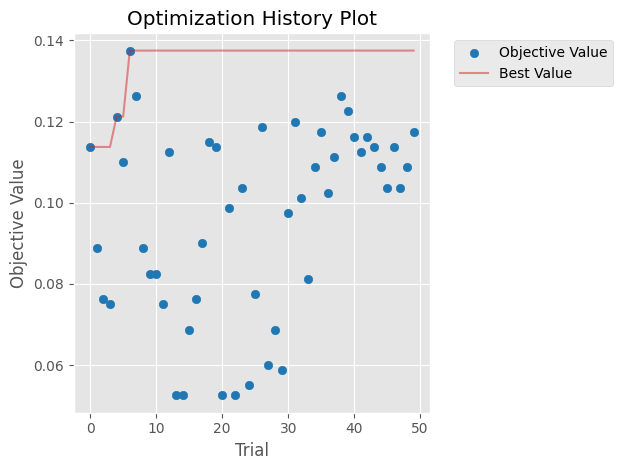

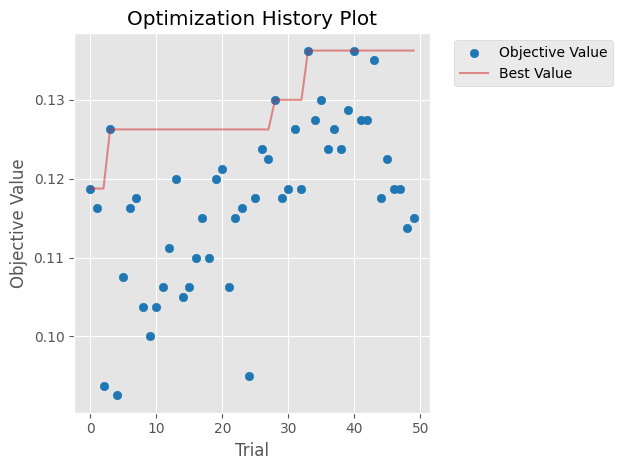

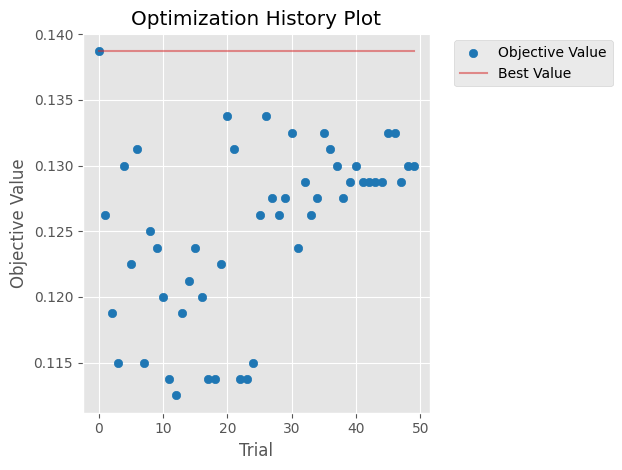

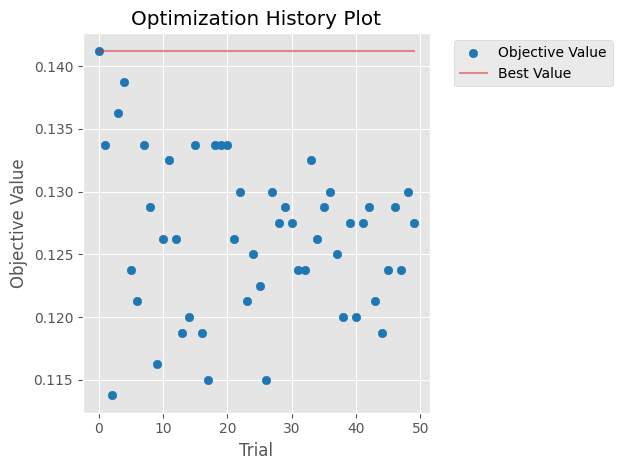

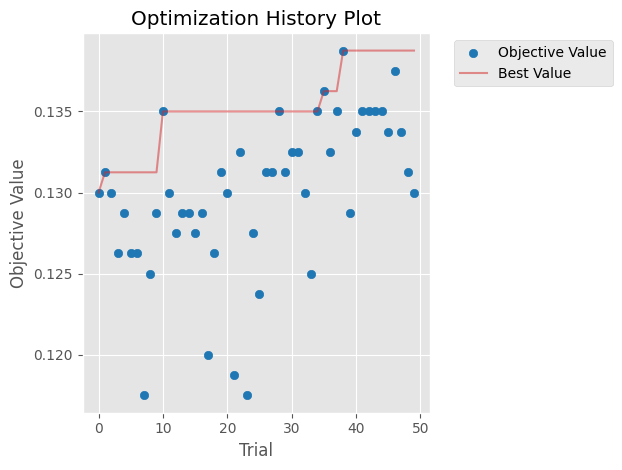

In [13]:
import optuna
import matplotlib.pyplot as plt

for study in llm_tuner.studies:
    fig = optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.tight_layout()

In [16]:
# Get just the best configuration
best_config = llm_tuner.get_best_config()
print("Best hyperparameters:", best_config)

# Get comprehensive summary
summary = llm_tuner.get_tuning_summary()
print(f"Best score: {summary['best_score']}")
print(f"Best config: {summary['best_config']}")

Best hyperparameters: {'n_estimators': 417, 'min_child_weight': 5.206455872368925, 'gamma': 1.0351144853617376, 'scale_pos_weight': 7.436452286633752, 'learning_rate': 0.00983200566541991, 'subsample': 0.905993682262866, 'colsample_bytree': 0.9448609291491337, 'colsample_bylevel': 0.9861854940510034, 'reg_alpha': 0.0016675645815358072, 'reg_lambda': 2.9286609921283974e-05}
Best score: 0.14125000000000001
Best config: {'n_estimators': 417, 'min_child_weight': 5.206455872368925, 'gamma': 1.0351144853617376, 'scale_pos_weight': 7.436452286633752, 'learning_rate': 0.00983200566541991, 'subsample': 0.905993682262866, 'colsample_bytree': 0.9448609291491337, 'colsample_bylevel': 0.9861854940510034, 'reg_alpha': 0.0016675645815358072, 'reg_lambda': 2.9286609921283974e-05}


In [17]:
x_df = X_transformed.drop('claim_status', axis=1)
y_df = X_transformed['claim_status']

In [18]:
if best_config:
    final_model = XGBClassifier(
        seed=42,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        use_label_encoder=False,
        verbosity=0,
        enable_categorical=False,
        **best_config)
    final_model.fit(x_df, y_df)

In [19]:
X_test_transformed = fe.transform(X_test)
X_test_transformed[categorical_cols] = encoder.transform(X_test_transformed[categorical_cols])

y_pred = final_model.predict(X_test_transformed)
y_pred_proba = final_model.predict_proba(X_test_transformed)[:, 1]

In [22]:
import math
import pandas as pd
from typing import Union


def metric_ppv(
    y_true: Union[list, pd.Series], 
    y_pred: Union[list, pd.Series], 
    top_p: float
) -> float:
    """
    Computes PPV at the top p% predicted probability scores.

    Args:
        y_true (Union[list, pd.Series]): Ground truth binary labels.
        y_pred (Union[list, pd.Series]): Predicted probabilities (not hard labels).
        top_p (float): Fraction (0 < top_p <= 1) of samples to include.

    Returns:
        float: Precision/PPV in the top_p most confident predictions.
    """
    if not (0 < top_p <= 1):
        raise ValueError("top_p must be between 0 and 1.")

    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must be the same length.")

    top_num = max(1, math.ceil(len(y_true) * top_p))

    ranked = pd.DataFrame({
        "label": pd.Series(y_true).values,
        "predicted_prob": pd.Series(y_pred).values,
    })

    top_ranked = ranked.sort_values("predicted_prob", ascending=False).head(top_num)
    ppv = top_ranked["label"].value_counts(normalize=True).get(1, 0.0)

    return ppv


metric_ppv(y_test, y_pred_proba, 0.05)

np.float64(0.125)